In [1]:
from collections import Counter
import mirdata
import numpy as np
import operator

msdb_instrument_dict = {
    "0": "clarinet",
    "1": "guitar",
    "2": "voice",
    "3": "flute",
    "4": "piano",
    "5": "saxophone",
    "6": "trumpet",
    "7": "violin"
}

msdb = mirdata.medley_solos_db.load()
n_songs = 227
n_samples_per_song = 16


# Select 8 samples per song
msdb_keys = []
for song_id in range(227):
    msdb_song = {
        key: msdb[key] for key in msdb.keys()
        if msdb[key].song_id == song_id
    }
    if msdb[list(msdb_song.keys())[0]].instrument == "female singer":
        song_keys = sorted(list(msdb_song.keys()))[:90]
        msdb_keys += song_keys
    elif len(msdb_song) >= n_samples_per_song:
        song_keys = sorted(list(msdb_song.keys()))[:n_samples_per_song]
        msdb_keys += song_keys
    
msdb4k_keys = msdb_keys[:4096]
msdb4k = {key: msdb[key] for key in msdb4k_keys}

AttributeError: module 'mirdata' has no attribute 'medley_solos_db'

In [40]:
import kymatio
import numpy
import scipy
import torch
import tqdm

input_length = 65536
n_scattering_scales = 14

scattering_transform = kymatio.Scattering1D(J=n_scattering_scales, shape=(input_length,))
hann_window = scipy.signal.hann(input_length, sym=False)

X_dict = {}

for msdb4k_key in tqdm.tqdm(list(msdb4k.keys())):
    waveform, sample_rate = msdb4k[msdb4k_key].audio
    windowed_waveform = hann_window * waveform
    normalized_waveform = waveform / np.linalg.norm(waveform)
    input_tensor = torch.Tensor(normalized_waveform)
    scattering_matrix = scattering_transform(input_tensor)
    n_frames = scattering_matrix.shape[1]
    scattering_matrix = scattering_matrix[:, (n_frames//4):(-n_frames//4)]
    scattering_vector = np.sum(
        scattering_matrix.numpy(), axis=1)
    X_dict[msdb4k_key] = scattering_vector

100%|██████████| 4096/4096 [15:31<00:00,  4.40it/s] 


In [43]:
import joblib
joblib.dump(X_dict, 'msdb4k_scattering.pkl')

['msdb4k_scattering.pkl']

In [46]:
X_dict = joblib.load('msdb4k_scattering.pkl')

In [169]:
#note that we use "test" as training and vice-versa
training_subset_str = 'test'
X_training_list = [
    X_dict[key] for key in msdb4k_keys
    if msdb4k[key].subset == training_subset_str]
X_training_matrix = np.maximum(
    0, np.stack(X_training_list))
X_training_normalizer = np.linalg.norm(
    X_training_matrix, axis=1)[:, np.newaxis]
X_training_matrix = X_training_matrix / X_training_normalizer
training_keys = [
    key for key in msdb4k_keys
    if msdb4k[key].subset == training_subset_str]

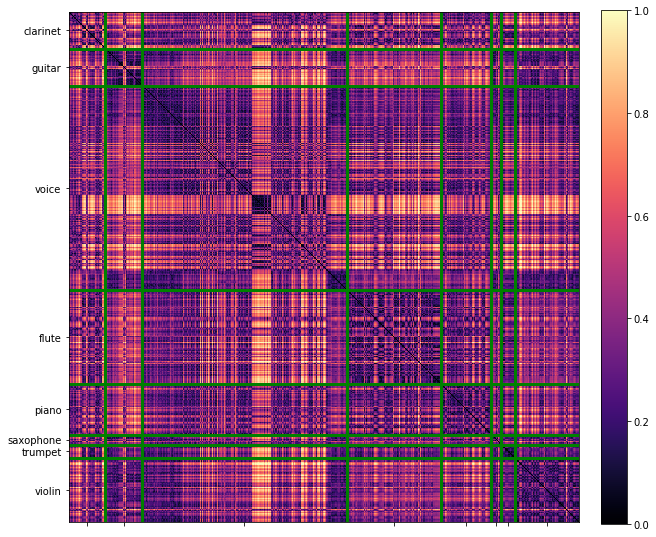

In [171]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

import sklearn.metrics

msdb_instrument_list = [pair[1] for pair in 
    sorted(msdb_instrument_dict.items(), key=operator.itemgetter(0))]

L_gram = sklearn.metrics.pairwise.linear_kernel(
    X_training_matrix)

L_euc = sklearn.metrics.pairwise.euclidean_distances(X_training_matrix)

instrument_ticks = np.where(np.diff(
    [msdb4k[key].instrument_id for key in training_keys]))[0]
n_training_keys = len(training_keys)

plt.figure(figsize=(10, 10))
plt.imshow(L_euc, cmap='magma')
plt.xlim(0, n_training_keys)
plt.ylim(0, n_training_keys)

plt.clim(0, 1)

for row_id in instrument_ticks:
    plt.plot([row_id, row_id], [0, n_training_keys], color='g', linewidth=3)
    plt.plot([0, n_training_keys], [row_id, row_id], color='g', linewidth=3)
    
ticks = np.array([0] + list(instrument_ticks)) + np.diff(
    [0] + list(instrument_ticks) + [n_training_keys])/2
plt.xticks(ticks)
plt.yticks(ticks)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().set_xticklabels([])
    
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().invert_yaxis()

[Text(0, 0, 'cl'),
 Text(0, 0, 'gu'),
 Text(0, 0, 'vo'),
 Text(0, 0, 'fl'),
 Text(0, 0, 'pi'),
 Text(0, 0, 'sa'),
 Text(0, 0, 'tr'),
 Text(0, 0, 'vi')]

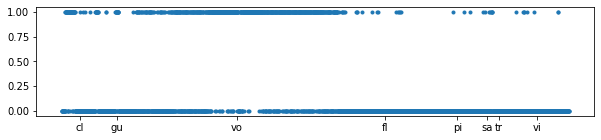

In [163]:
from sklearn.linear_model import LogisticRegression

y_training = np.array([
    msdb4k[key].instrument == "female singer"
    for key in training_keys
]).astype('int')


clf = LogisticRegression(solver='lbfgs')
clf.fit(X_training_matrix, y_training)

y_training_pred = clf.predict(X_training_matrix)
plt.figure(figsize=(10, 2))
plt.plot(y_training_pred, '.')
plt.xticks(ticks)
plt.gca().set_xticklabels([x[:2] for x in msdb_instrument_list])

In [258]:
# again, note that training and test are permuted wrt original msdb subsets
test_subset_str = 'training'
X_test_list = [
    X_dict[key] for key in msdb4k_keys
    if msdb4k[key].subset == test_subset_str]
X_test_matrix = np.maximum(
    0, np.stack(X_test_list))
X_test_normalizer = np.linalg.norm(
    X_test_matrix, axis=1)[:, np.newaxis]
X_test_matrix = X_test_matrix / X_test_normalizer
test_keys = [
    key for key in msdb4k_keys
    if msdb4k[key].subset == test_subset_str]
y_test_pred = clf.predict_proba(X_test_matrix)[:, 1]
Z_test_matrix = X_test_matrix * np.sqrt(y_test_pred[:, np.newaxis])

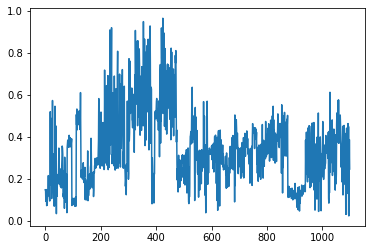

In [259]:
plt.plot(y_test_pred)

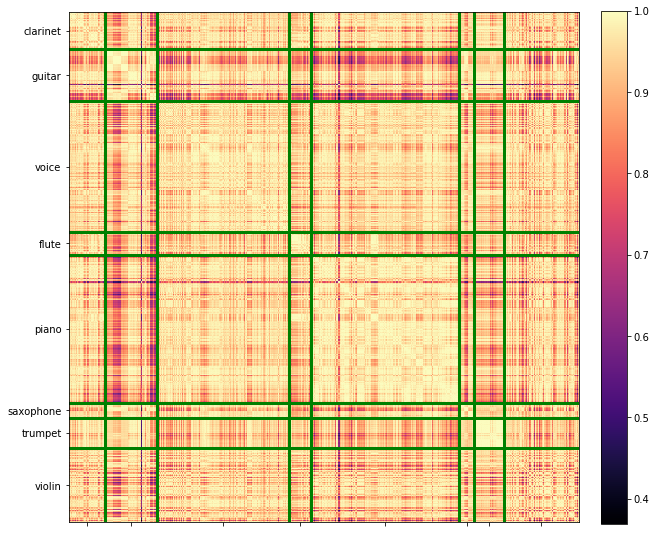

In [260]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

import sklearn.metrics

msdb_instrument_list = [pair[1] for pair in 
    sorted(msdb_instrument_dict.items(), key=operator.itemgetter(0))]

L_gram_X = sklearn.metrics.pairwise.linear_kernel(
    X_test_matrix)

instrument_ticks = np.where(np.diff(
    [msdb4k[key].instrument_id for key in test_keys]))[0]
n_test_keys = len(test_keys)

plt.figure(figsize=(10, 10))
plt.imshow(L_gram_X, cmap='magma')
plt.xlim(0, n_test_keys)
plt.ylim(0, n_test_keys)


for row_id in instrument_ticks:
    plt.plot([row_id, row_id], [0, n_test_keys], color='g', linewidth=3)
    plt.plot([0, n_test_keys], [row_id, row_id], color='g', linewidth=3)
    
ticks = np.array([0] + list(instrument_ticks)) + np.diff(
    [0] + list(instrument_ticks) + [n_test_keys])/2
plt.xticks(ticks)
plt.yticks(ticks)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().set_xticklabels([])
    
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().invert_yaxis()

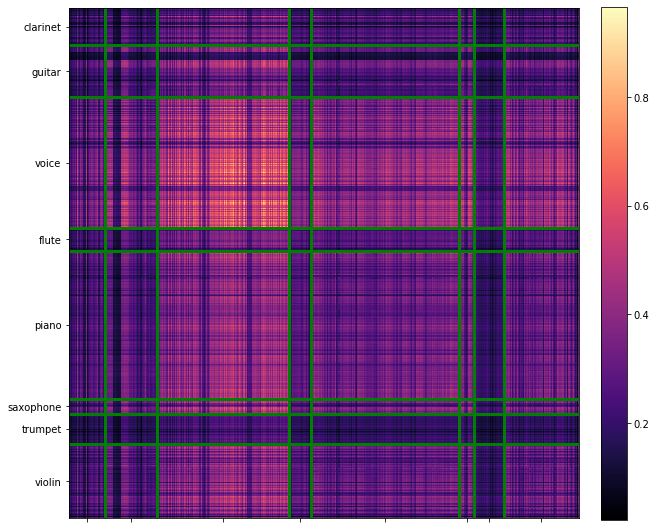

In [261]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

import sklearn.metrics

msdb_instrument_list = [pair[1] for pair in 
    sorted(msdb_instrument_dict.items(), key=operator.itemgetter(0))]

L_gram = sklearn.metrics.pairwise.linear_kernel(
    Z_test_matrix)

instrument_ticks = np.where(np.diff(
    [msdb4k[key].instrument_id for key in test_keys]))[0]
n_test_keys = len(test_keys)

plt.figure(figsize=(10, 10))
plt.imshow(L_gram, cmap='magma')
plt.xlim(0, n_test_keys)
plt.ylim(0, n_test_keys)


for row_id in instrument_ticks:
    plt.plot([row_id, row_id], [0, n_test_keys], color='g', linewidth=3)
    plt.plot([0, n_test_keys], [row_id, row_id], color='g', linewidth=3)
    
ticks = np.array([0] + list(instrument_ticks)) + np.diff(
    [0] + list(instrument_ticks) + [n_test_keys])/2
plt.xticks(ticks)
plt.yticks(ticks)
plt.gca().set_yticklabels(msdb_instrument_list)
plt.gca().set_xticklabels([])
    
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().invert_yaxis()

In [262]:
print(Counter([msdb[key].instrument for key in pos_test_keys]))
pos_test_keys = [
    key for key_id, key in enumerate(test_keys) if y_test_pred[key_id]>0.5]

Counter({'female singer': 158, 'piano': 12, 'distorted electric guitar': 7, 'violin': 6, 'tenor saxophone': 4, 'clarinet': 3})


In [263]:
import dppy.finite_dpps



detpop_lengths = []
random_lengths = []
n_trials = 50

detpop_accs = []
random_accs = []

for trial_id in tqdm.tqdm(range(n_trials)):
    
    detpop = dppy.finite_dpps.FiniteDPP(kernel_type='likelihood', L=L_gram)
    detpop.sample_exact_k_dpp(32)
    detpop_ids = detpop.list_of_samples[0]

    detpop_song_counter = Counter([
        msdb4k[msdb4k_keys[detpop_id]].song_id
        for detpop_id in detpop_ids])
    detpop_lengths.append(len(detpop_song_counter))
    detpop_accs.append(np.mean(np.array([
        msdb4k[msdb4k_keys[detpop_id]].instrument == 'female singer'
        for detpop_id in detpop_ids
    ]).astype('float')))

    random_ids = np.random.choice(range(len(pos_test_keys)), size=32, replace=False)
    random_song_counter = Counter([
        msdb4k[pos_test_keys[random_id]].song_id
        for random_id in random_ids
    ])
    random_lengths.append(len(random_song_counter))
    random_accs.append(np.mean(np.array([
        msdb4k[pos_test_keys[random_id]].instrument == 'female singer'
        for random_id in random_ids
    ]).astype('float')))
    
    


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


In [234]:
detpop_ids

array([ 584,  451,  351,  229,  332,  541,  337,  407,  268,  358,  340,
        530,  296,  346, 1058,  237, 1027,  537,  461,  446,  377,  379,
        839,  220,  275,  425,  327,  822,  344,  308,  120,  985])

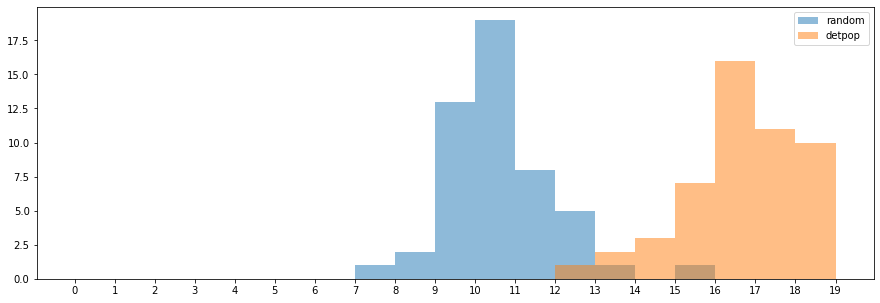

In [264]:
plt.figure(figsize=(15, 5))
plt.hist(random_lengths, bins=range(20), label="random", alpha=0.5)
plt.hist(detpop_lengths, bins=range(20), label="detpop", alpha=0.5)
plt.xticks(range(20));
plt.legend()

(0, 1)

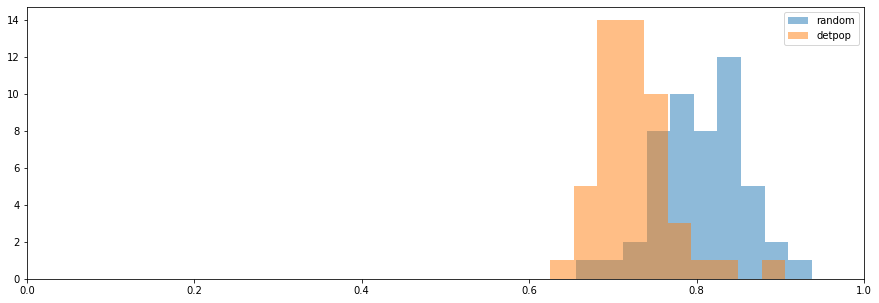

In [265]:
plt.figure(figsize=(15, 5))
plt.hist(random_accs, label="random", alpha=0.5)
plt.hist(detpop_accs, label="detpop", alpha=0.5)
plt.legend()
plt.xlim(0, 1)

In [269]:
from IPython.display import Audio, display

detpop_keys = [msdb4k_keys[detpop_id] for detpop_id in detpop_ids]

for detpop_key in detpop_keys:
    display(Audio(msdb4k[detpop_key].audio[0][:32768], rate=22050))

In [273]:
eigvals = scipy.linalg.svd(X_test_matrix)

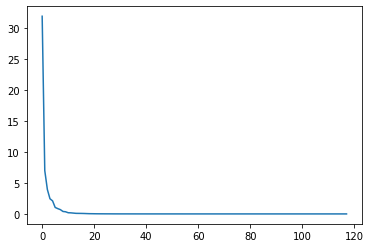

In [283]:
plt.plot((eigvals[1]));

In [280]:
eigvals[1].shape

(118,)